<a href="https://colab.research.google.com/github/Het-Shah/BreastCancerDetection/blob/master/Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from PIL import Image
import numpy as np 
import pandas as pd 
import cv2 as cv
from matplotlib import pyplot as plt 
from glob import glob
import torch
import torchvision
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torchvision import datasets,transforms


%matplotlib inline

In [0]:
!gdown https://drive.google.com/uc?id=1r6YNGwijUHawsRHKy8qQk12FW-VQXw4p
!unzip -qq b_cancer_data2.zip

Downloading...
From: https://drive.google.com/uc?id=1r6YNGwijUHawsRHKy8qQk12FW-VQXw4p
To: /content/b_cancer_data2.zip
4.28GB [00:29, 147MB/s]


In [0]:
!ls -l ./b_cancer_data2/train/BENIGN/ | wc -l
!ls -l ./b_cancer_data2/train/MALIGNANT/ | wc -l
!ls -l ./b_cancer_data2/valid/BENIGN/ | wc -l
!ls -l ./b_cancer_data2/valid/MALIGNANT/ | wc -l

1807
4542
677
891


In [0]:
class B_Cancer_Dataset():
  def __init__(self, path, train=1, transforms = None):
    self.path = path
    if train:
      self.path = self.path + "/train"
    else:
      self.path = self.path + "/valid"
    self.transforms = transforms
    self.benign = sorted(glob(os.path.join(self.path, "BENIGN", "*.png")))
    self.malignant = sorted(glob(os.path.join(self.path, "MALIGNANT", "*.png")))
    self.list = [(b,0) for b in self.benign] + [(m,1) for m in self.malignant]
    
  def __len__(self):
    return len(self.list)
  
  def __getitem__(self, idx):
    image = self.list[idx][0]
    label = self.list[idx][1]
#     if label:
# #       image = os.path.join(self.path,"MALIGNANT/",image)
#     else:
# #       image = os.path.join(self.path,"BENIGN/", image)
    img = Image.open(image)
    
    if self.transforms:
      img = self.transforms(img)
      
    return (img, label)  


In [0]:
train_Transform= transforms.Compose([
                                     transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_Transform = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train = B_Cancer_Dataset("./b_cancer_data2",1,train_Transform)
train_loader = torch.utils.data.DataLoader(train,batch_size=10,shuffle=True)
print(train.list)

val = B_Cancer_Dataset("./b_cancer_data2",0,val_Transform)
val_loader = torch.utils.data.DataLoader(val,batch_size=10)
print(val.list)

[('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-001.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-002.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-003.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-004.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-005.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-006.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-007.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-008.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-009.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-010.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-011.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-012.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-013.png', 0), ('./b_cancer_data2/train/BENIGN/SOB_B_A-14-22549CD-100-014.png', 0), ('./b_cancer_data2/train/BENIGN/S

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


Text(0.5, 1.0, 'tensor(0)')

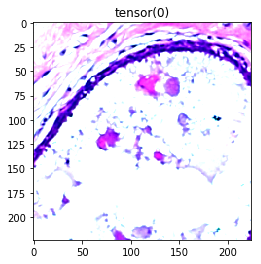

In [0]:
valiter = iter(val_loader)
img, label = valiter.next()
img = img[0].numpy()
print(img.shape)
plt.imshow(np.transpose(img,(1,2,0)))
plt.title(str(label[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


Text(0.5, 1.0, 'tensor(0)')

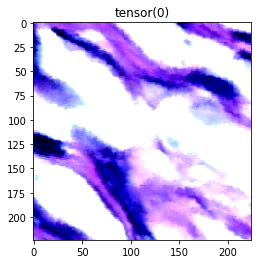

In [0]:
trainiter = iter(train_loader)
img, label = trainiter.next()
# plt.imshow(img)
# plt.title(label)
img = img[0].numpy()
print(img.shape)
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title(str(label[0]))

In [0]:
model = torchvision.models.resnext101_32x8d(pretrained=True, progress=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 356082095/356082095 [00:02<00:00, 139779133.20it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [0]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048,2,bias=True)
model = model.cuda()

In [0]:
from torchsummary import summary

In [0]:
summary(model,input_size=((3, 224, 224)),batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 112, 112]           9,408
       BatchNorm2d-2         [10, 64, 112, 112]             128
              ReLU-3         [10, 64, 112, 112]               0
         MaxPool2d-4           [10, 64, 56, 56]               0
            Conv2d-5          [10, 256, 56, 56]          16,384
       BatchNorm2d-6          [10, 256, 56, 56]             512
              ReLU-7          [10, 256, 56, 56]               0
            Conv2d-8          [10, 256, 56, 56]          18,432
       BatchNorm2d-9          [10, 256, 56, 56]             512
             ReLU-10          [10, 256, 56, 56]               0
           Conv2d-11          [10, 256, 56, 56]          65,536
      BatchNorm2d-12          [10, 256, 56, 56]             512
           Conv2d-13          [10, 256, 56, 56]          16,384
      BatchNorm2d-14          [10, 256,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,betas=(0.5, 0.9))

In [0]:
num_epochs = 15
len_train = len(train)
len_valid = len(val)
try:
  for epoch in range(num_epochs):
    print("EPOCH {}/{}".format(epoch,num_epochs-1))
    print("-"*10)
    
    running_loss = 0.0
    running_corrects = 0
    
    model.train()
    for i, data in enumerate(train_loader,0):
      optimizer.zero_grad()
      input,target = data
      input = Variable(input).cuda()
      target = Variable(target).cuda()
      output = model(input)
      _, preds = torch.max(output, 1)
#       print(output.shape)
#       print(target.shape)
      loss = criterion(output, target)
      
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * input.detach().size(0)
      running_corrects += torch.sum(preds==target.detach().data)
    
    epoch_loss = running_loss / len_train
    epoch_acc = running_corrects.double() / len_train
    print("TRAIN LOSS : {}, TRAIN ACC : {}".format(epoch_loss,epoch_acc))
    
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for i, data in enumerate(val_loader,0):
      input,target = data
      input = Variable(input).cuda()
      target = Variable(target).cuda()
      with torch.no_grad():
        output = model(input)
      _,preds = torch.max(output,1)
      loss = criterion(output,target)
      
      running_loss += loss.item() * input.detach().size(0)
      running_corrects += torch.sum(preds == target.detach().data)
    
    epoch_loss = running_loss / len_valid
    epoch_acc = running_corrects.double() / len_valid
    print("VALID LOSS : {}, VALID ACC : {}".format(epoch_loss,epoch_acc))
      
except KeyboardInterrupt:
  print("Interrupted")

EPOCH 0/14
----------
TRAIN LOSS : 4.65938551202237, TRAIN ACC : 0.7883372734436564
VALID LOSS : 2.139431227591772, VALID ACC : 0.8580562659846548
EPOCH 1/14
----------
TRAIN LOSS : 4.2690263307922685, TRAIN ACC : 0.8
VALID LOSS : 2.6132860489308087, VALID ACC : 0.8273657289002558
EPOCH 2/14
----------
TRAIN LOSS : 4.062583617677218, TRAIN ACC : 0.8012608353033885
VALID LOSS : 2.061759258271139, VALID ACC : 0.8497442455242967
EPOCH 3/14
----------
TRAIN LOSS : 3.7887371439168605, TRAIN ACC : 0.805043341213554
VALID LOSS : 2.226985759586341, VALID ACC : 0.8331202046035806
EPOCH 4/14
----------
TRAIN LOSS : 3.5014668297859375, TRAIN ACC : 0.807565011820331
VALID LOSS : 2.1729462965278854, VALID ACC : 0.8331202046035806
EPOCH 5/14
----------
TRAIN LOSS : 3.3694028453950526, TRAIN ACC : 0.8119779353821908
VALID LOSS : 2.125209279805344, VALID ACC : 0.8280051150895141
EPOCH 6/14
----------
TRAIN LOSS : 3.190827765402464, TRAIN ACC : 0.805043341213554
VALID LOSS : 2.1202313292771398, VALID A

In [0]:
torch.save(model, "/content/model_wts.pt")